In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np

import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

BAD_RXNS = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25.",
            "DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.",
            'DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71.']


from convex_kinetics_new import ConvexKineticsNew
from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [35]:
time = '10'
date = '2023-04-21'
experiment = 'fba-redux'
entry = f'{experiment}_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [36]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [37]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [38]:
stoichiometry = agent['ecoli-metabolism-redux'].stoichiometry

Pandas automatically understands dicts of dicts as matrices.

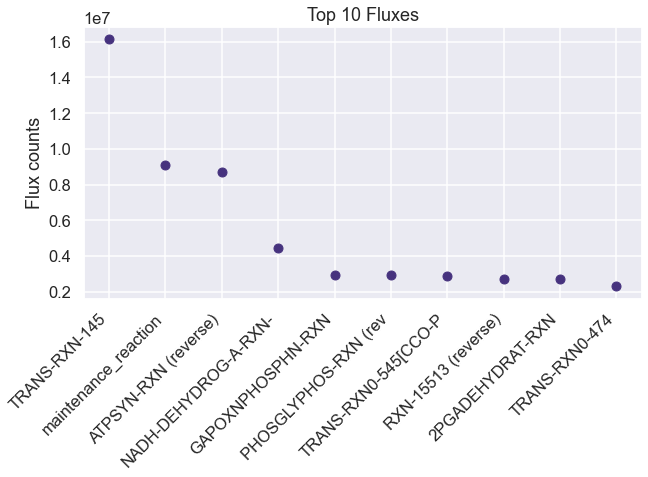

In [39]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))
sim_fluxes.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(10, 5))
plt.plot(sim_fluxes.head(10), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(10)], [i[:20] for i in sim_fluxes.index[:10]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar


plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

In [40]:
sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"])
sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
sim_catalysts

,4
RXN0-1741-MALTOSE//MALTOSE.17.,40249
RXN-15315,40223
TRANS-RXN0-445-CHITOBIOSE//CHITOBIOSE.23.,40223
RXN0-0-N-ACETYLNEURAMINATE//N-ACETYLNEURAMINATE.41.,40223
RXN0-0-N-ACETYLNEURAMINATE//CPD0-1123.31.,40223
...,...
TRANS-RXN-100,0
RXN-17726-CPD-3561/WATER//GALACTOSE/CPD-10723.36.,0
RXN-17726-CPD-3561/WATER//GALACTOSE/BETA-D-FRUCTOSE.42.,0
RXN-17726,0


# Test changing nutrient composition

In [41]:
uptake = (fba["unconstrained_molecules"][3]).copy()
uptake_c = fba["constrained_molecules"]

uptake.extend(list(uptake_c.keys()))
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'FE+2[p]',
 'FRU[p]',
 'K+[p]',
 'L-SELENOCYSTEINE[c]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'Pi[p]',
 'SULFATE[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [42]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"]).loc[4, :]
exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"]).loc[4, :]
maintenance = pd.DataFrame(fba["maintenance_target"]).at[4, 'maintenance_reaction']
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"]).loc[4, :]
homeostatic

2-3-DIHYDROXYBENZOATE[c]     73.0
2-KETOGLUTARATE[c]          186.0
2-PG[c]                      49.0
2K-4CH3-PENTANOATE[c]        73.0
4-AMINO-BUTYRATE[c]         160.0
                            ...  
MN+2[p]                      52.0
NA+[p]                       52.0
OXYGEN-MOLECULE[p]           51.0
CA+2[p]                      52.0
Pi[p]                        52.0
Name: 4, Length: 171, dtype: float64

In [43]:
stoichiometry
stoichiometric_matrix_dict = {item["reaction id"]: item["stoichiometry"] for item in stoichiometry}

In [44]:
model = NetworkFlowModel(reactions=stoichiometric_matrix_dict, homeostatic_metabolites=list(dict(homeostatic).keys()))

In [45]:
model.set_up_exchanges(exchanges=list(dict(exchanges).keys()), uptakes=uptake)

/Users/cyrus/vivarium-ecoli/ecoli/processes/metabolism_redux.py:405: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.Se.at[met, exch_name + " rev"] = -1
/Users/cyrus/vivarium-ecoli/ecoli/processes/metabolism_redux.py:402: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.Se.at[met, exch_name] = 1


In [53]:
solution: FlowResult = model.solve(homeostatic_targets=dict(homeostatic),
                                   maintenance_target=maintenance,
                                   kinetic_targets=dict(kinetic),
                                   reaction_catalyst_counts=sim_catalysts.to_dict()[4],
                                   water_transport_reaction='TRANS-RXN-145',
                                   objective_weights={'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001},
                                   upper_flux_bound=100000000)

In [54]:
pd.Series(solution.exchanges).sort_values(ascending=False).head(10)

WATER[p]               1.676488e+07
OXYGEN-MOLECULE[p]     2.935431e+06
FRU[p]                 1.327671e+06
L-SELENOCYSTEINE[c]    8.353830e+05
AMMONIUM[c]            5.383090e+05
Pi[p]                  1.764350e+05
K+[p]                  5.093300e+04
SULFATE[p]             3.325200e+04
MG+2[p]                2.263000e+03
FE+2[p]                1.911000e+03
dtype: float64

In [48]:
pd.Series(solution.velocities).sort_values(ascending=False).head(10)

TRANS-RXN-145                                                               1.676488e+07
ATPSYN-RXN (reverse)                                                        1.064278e+07
maintenance_reaction                                                        9.067240e+06
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.       4.829047e+06
TRANS-RXN0-474                                                              2.935380e+06
RXN-21817-CPD-9956/PROTON/OXYGEN-MOLECULE//UBIQUINONE-8/PROTON/WATER.59.    2.935303e+06
PYRUVDEH-RXN                                                                2.070046e+06
GAPOXNPHOSPHN-RXN                                                           1.658754e+06
PHOSGLYPHOS-RXN (reverse)                                                   1.658746e+06
3PGAREARR-RXN (reverse)                                                     1.436160e+06
dtype: float64

In [23]:
model.Sd.loc[:, "FUMHYDR-RXN__FUMARASE-A"].sort_values(ascending=False).head(10)

WATER[c]                  1
FUM[c]                    1
ACYL-SN-GLYCEROL-3P[c]    0
CPD-15826[p]              0
CPD-16168[p]              0
CPD-16154[e]              0
CPD-16154[p]              0
CPD-15895[e]              0
CPD-15828[e]              0
CPD-15828[p]              0
Name: FUMHYDR-RXN__FUMARASE-A, dtype: int8

In [25]:
model.Sd.loc[:, "FUMHYDR-RXN__FUMARASE-A (reverse)"].sort_values(ascending=True).head(10)

FUM[c]                   -1
WATER[c]                 -1
CPD-16154[e]              0
CPD-16154[p]              0
CPD-15895[e]              0
CPD-15828[e]              0
CPD-15828[p]              0
CPD-15826[e]              0
CPD-15826[p]              0
ACYL-SN-GLYCEROL-3P[c]    0
Name: FUMHYDR-RXN__FUMARASE-A (reverse), dtype: int8

In [33]:
for rxn in stoichiometry:
    if rxn['reaction id'] == 'TRANS-RXN-145':
        print(rxn)

{'reaction id': 'TRANS-RXN-145', 'stoichiometry': {'WATER[p]': -1, 'WATER[c]': 1}, 'enzyme': ['CPLX0-7653[m]']}


# Filter S matrix to only include nonzero fluxes.

In [ ]:
# only include nonzero fluxes in solution.velocities
nonzero_velocities = {k: v for k, v in solution.velocities.items() if v != 0}

In [ ]:
# Use nonzero_velocities to filter S matrix
S_matrix = model.Sd.loc[:, nonzero_velocities.keys()]

# remove rows of S_used that sum to zero.
S_matrix = S_matrix.loc[(S_matrix != 0).any(axis=1)]

In [ ]:
nonzero_velocities

In [ ]:
S_matrix

# Normalize velocities to enzyme counts

In [ ]:
# divide velocities by enzyme counts
nvE_dict = {k: nonzero_velocities[k] / sim_catalysts[k] for k in S_matrix.columns}

# First test. Single flux set. No eQuilibrator or regulation.

In [ ]:
# sort nonzero_velocities to be in same order as S_matrix columns.
vE_dict = {k: nonzero_velocities[k] for k in S_matrix.columns}
vE = np.array([np.array(list(vE_dict.values()))])

In [ ]:
Sd = S_matrix
# Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

Sd

In [ ]:
S_array = np.array(Sd)

# count number of times a value occurs in S_array
np.unique(S_array, return_counts=True)

In [ ]:
# K_eq = np.log(keq)
# K_eq_mod = K_eq[:, np.newaxis].T
# vE = np.array([[90, 70, -30, 50], [100, 100, 30, 50], [110, 60, 75, 50]])

# n_flux_set = vE.shape[0]
# n_flux_set = 1
Sr = None

# K_eq[vE < 0] = 1/K_eq[vE < 0]

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([vE, np.sign(vE)]), columns=Sd.columns,
             index=["$v_1$", "sign 1"])

# Use the class based method to solve the problem

In [ ]:
E = ConvexKineticsNew()
y_f, y_r, y_s, y_p, y_i, y_a, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE)

In [ ]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

In [ ]:
Sd.iloc[:, 127:130]

In [ ]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, d_beta, S_s_nz, S_p_nz, S, y_f, y_r, y_s, y_p, cfwd, crev)

In [ ]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, LSE_expr, denom_expr)

In [ ]:
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, lower_bound=-12, upper_bound=18)

In [ ]:
problem = E.set_up_problem(loss, constr)


In [ ]:
solution = E.solve(problem)


In [ ]:
solution.value

Should be around 52

In [ ]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

In [ ]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
# df_reconstr_comp



In [ ]:
df_reconstr_comp

In [ ]:
# sort df_reconstr_comp by value
df_reconstr_comp = df_reconstr_comp.sort_values(by="value", ascending=False).reset_index(drop=True)

sns.catplot(y="variable", x="value", hue="kind", data=df_reconstr_comp.iloc[0:60,:], kind="bar", height=10, aspect=0.5)

# change x axis to log scale
plt.xscale('log')

# limit length of y axis labels to 20 characters
plt.gca().set_yticklabels([t.get_text()[:20] for t in plt.gca().get_yticklabels()])

In [ ]:
Sd.loc[:, "ADCLY-RXN"]